# Load HCP parcellated task data 
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nilearn

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames[-1] = [i for i in frames[-1] if i < data.shape[1]]
    frames_list.append(frames)

  return frames_list

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [ ]:
my_exp = 'LANGUAGE'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)



(360, 316)


As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [ ]:
evs[0]

[array([38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56]),
 array([56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
        73]),
 array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]),
 array([193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210]),
 array([211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
        224, 225, 226]),
 array([227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
        240, 241, 242, 243]),
 array([246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262, 263]),
 array([264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
        277, 278, 279, 280]),
 array([281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
        294, 295, 296, 297, 298]),
 [299,
  300,
  301,
  302,
  303,
  304,
  305,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  314

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions. 

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


story_activity = average_frames(data, evs, my_exp, 'story')
math_activity = average_frames(data, evs, my_exp, 'math')
contrast = story_activity - math_activity  # difference between left and right hand movement

In [ ]:
def block_glm_binaries(data, evs, experiment, cond):
  
  # Find indices/time points of conditions (e.g., math or story)
  idx = EXPERIMENTS[experiment]['cond'].index(cond) # get the index of the condition
  blocks = [evs[idx][i] for i in range(len(evs[idx]))] # concatenate index for condition
  
  # Create binarized vector of conditions
  bins = np.zeros((len(evs[idx]), data.shape[1]))
  for b in range(0, len(blocks)):
     bin = np.zeros(data.shape[1]) # instantiate binary vector
     bin[blocks[b]] = 1 # make identified indices one 
     bins[b] = bin
  return bins

In [ ]:
def block_tdm_binary(data, evs, experiment, cond):
  
  # Find indices/time points of conditions (e.g., math or story)
  idx = EXPERIMENTS[experiment]['cond'].index(cond) # get the index of the condition
  block = np.concatenate([evs[idx][i] for i in range(len(evs[idx]))], axis=-1) # concatenate index for condition
  
  # Create binarized vector of conditions
  bin = np.zeros(data.shape[1]) # instantiate binary vector
  bin[block] = 1 # make identified indices one 
  return bin

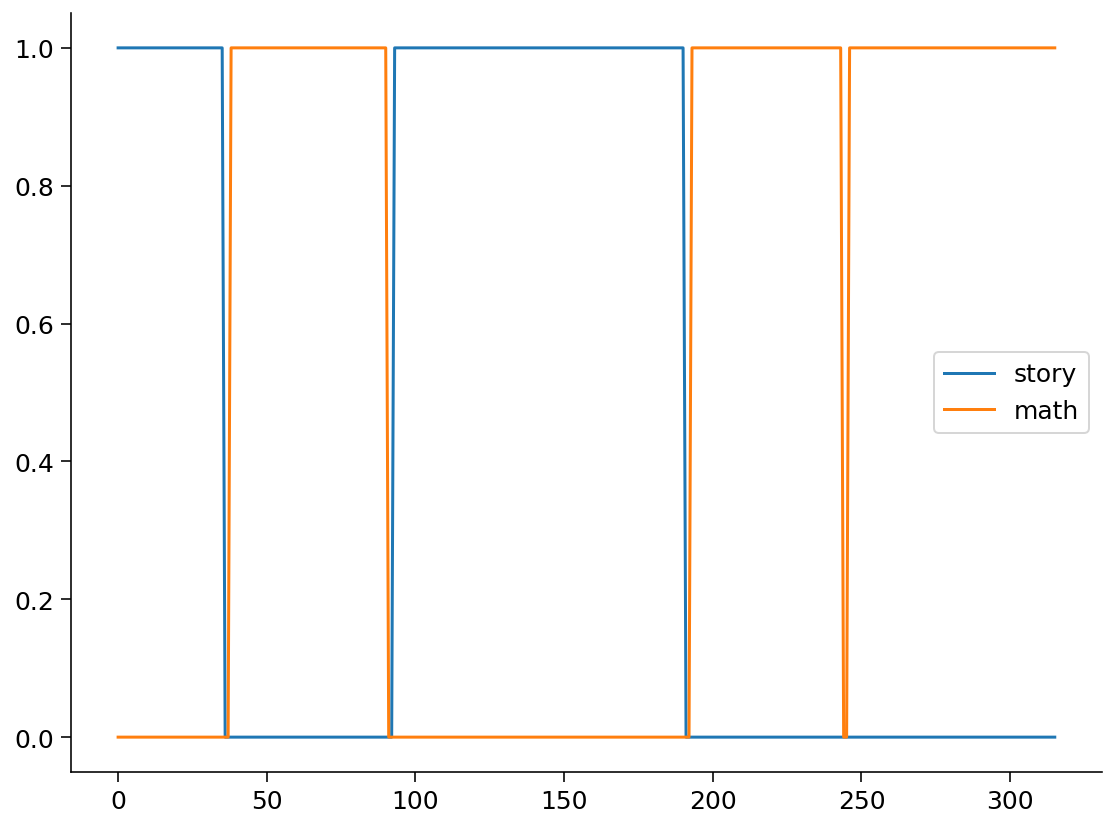

In [ ]:
# Plot story and math blocks
plt.figure()
plt.plot(block_tdm_binary(data, evs, my_exp, 'story'), label='story')
plt.plot(block_tdm_binary(data, evs, my_exp, 'math'), label='math')
plt.legend()
plt.show()

In [ ]:
story_bin = block_tdm_binary(data, evs, my_exp, 'story')
math_bin = block_tdm_binary(data, evs, my_exp, 'math')

In [ ]:
def get_HRF(duration, TR, peak):
  """
  Really dumb Haemodynamic response function (not physiologically plausible)
  It simply goes up and down linearly from 0 to peak and back down

  Args:
    duration (float) : in seconds
    TR (float)       : in seconds
    peak (float)     : in seconds

  Returns:
    1D array
  """
  n = int(np.ceil(duration / TR))
  x = np.linspace(0, duration, n)
  h = np.zeros(n)
  h[x < peak]  = x[x < peak] / peak
  h[x >= peak] = (x[x >= peak] - duration) / (peak - duration)
  h = h / np.sum(h)
  return h

In [ ]:
plt.plot( nilearn.glm.first_level.spm_hrf(TR, oversampling=50, time_length=10.0, onset=0.0))

AttributeError: ignored

In [ ]:
HRF = get_HRF(duration=10, TR=1, peak=3) #nilearn.glm.first_level.spm_hrf(TR, oversampling=50, time_length=32.0, onset=0.0)

ev1 = np.convolve(story_bin, HRF, 'full')[:data.shape[1]]
ev2 = np.convolve(math_bin, HRF, 'full')[:data.shape[1]]

# plot the new EVs:
plt.figure()
plt.plot(math_bin)
plt.plot(ev1)
plt.show()

plt.figure()
plt.plot(story_bin)
plt.plot(ev2)
plt.show()

In [ ]:
# append a constant regressor
design_matrix = np.asarray([story_bin, math_bin, np.ones_like(ev1)]).T
print(design_matrix.shape)

In [ ]:
def glm(Y, X, C=None, mask=None):
  """
  Run a general linear model

  Args:
    Y (2d array) : time-by-space data matrix
    X (2d array) : time-by-regressors design matrix
    C (2d array) : contrasts-by-regressor contrrast matrix [default=Identity]
    mask (1d array) : spatial mask wherre GLM is run

  Returns:
    contrast maps
    t-stats
  """
  if C is None:
    C = np.identity(X.shape[1])
  if mask is None:
    mask = np.ones(Y.shape[1])

  # initialise matrices
  beta = np.zeros((X.shape[1], Y.shape[1]))
  cope = np.zeros((C.shape[0], Y.shape[1]))
  varbeta = np.zeros_like(beta)
  tstat = np.zeros_like(beta)

  # solve glm
  beta[:, mask > 0] = np.linalg.pinv(X) @ Y[:, mask > 0]
  # apply contrasts
  cope[:, mask > 0] = np.dot(C, beta[:, mask > 0])

  # calculate uncertainty (varcope)
  r = Y - X@beta
  dof = X.shape[0] - np.linalg.matrix_rank(X)
  sig2 = np.sum(r**2, axis=0) / dof
  varcope = np.outer(C @ np.diag(np.linalg.inv(X.T @ X)) @ C.T, sig2)
  # calculate t-stats
  tstat[:, mask] = cope[:, mask] / np.sqrt(varcope[:, mask])

  return cope, tstat

In [ ]:
Y = data.T

# create a mask where data is non-zero
mask = np.sum(Y**2, axis=0)>0

# run GLM
beta, t = glm(Y=Y, X=design_matrix, mask=mask)


In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    story_activity = average_frames(data, evs, my_exp, 'story')
    math_activity = average_frames(data, evs, my_exp, 'math')

    contrast = story_activity - math_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

## Standard GLM

In [ ]:
block_glm_binaries(data, evs, 'LANGUAGE', 'math')

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [ ]:
def gen_glm_design_matrix(data, evs, experiment, conds):
  
  design_matrix = np.ones((data.shape[1], len(evs[0]) + len(evs[1] + 1)))
  idx = 1
  for i in range(0,len(evs[0])+len(evs[1])):
    if i < len(evs[0]):
        design_matrix[:, idx] = block_binary(data, evs, experiment, 0) 
    else:
        design_matrix[:, idx] = block_binary(data, evs, experiment, 1)
    idx += 1
  return design_matrix

In [ ]:
my_exp = 'LANGUAGE'

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, random_state=2022)

for subj in subjects:
    print(subj)

    # Extract timeseries
    bold_train, bold_test = load_single_timeseries(subj, my_exp, 0, remove_mean = False), load_single_timeseries(subj, my_exp, 1, remove_mean = False)  

    # Extract events
    evs_train, evs_test = load_evs(subj, my_exp, 0), load_evs(subj, my_exp, 1)

    # Determine average block length for a participant
    # ...

    # Create design matrices
    design_train = gen_design_matrix(bold_train, evs_train, my_exp, ['story', 'math'])

    print(design_train.shape)

    plt.figure()
    plt.plot(design_train[:, 1], label='story')
    plt.plot(design_train[:, 2], label='math')
    plt.legend()
    plt.show()

    # Generate beta values
    model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
    model.fit(design_train, bold_train.T)
    beta = model.coef_

    # Calculate estimated design matrix
    design_test = bold_test.T @ beta

    # Create predictor
    y_hat = block_binary(bold_test, evs_test, my_exp, 'story')


## Time decoding model

In [ ]:
def gen_tdm_design_matrix(data, evs, experiment, conds):
  design_matrix = np.ones((data.shape[1], len(conds)+1))
  idx = 1
  for cond in conds:
    design_matrix[:, idx] = block_binary(data, evs, experiment, cond) 
    #np.convole(block_binary(data, evs, experiment, cond), HRF, 'full')[:data.shape[1]]    
    #np.convolve(story_bin, HRF, 'full')[:data.shape[1]]
    idx += 1
  return design_matrix

In [ ]:
my_exp = 'LANGUAGE'

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, random_state=2022)

for subj in subjects:
    print(subj)

    # Extract timeseries
    bold_train, bold_test = load_single_timeseries(subj, my_exp, 0, remove_mean = False), load_single_timeseries(subj, my_exp, 1, remove_mean = False)  

    # Extract events
    evs_train, evs_test = load_evs(subj, my_exp, 0), load_evs(subj, my_exp, 1)

    # Determine average block length for a participant
    # ...

    # Create design matrices
    design_train = gen_design_matrix(bold_train, evs_train, my_exp, ['story', 'math'])

    print(design_train.shape)

    plt.figure()
    plt.plot(design_train[:, 1], label='story')
    plt.plot(design_train[:, 2], label='math')
    plt.legend()
    plt.show()

    # Generate beta values
    model = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')
    model.fit(design_train, bold_train.T)
    beta = model.coef_

    # Calculate estimated design matrix
    design_test = bold_test.T @ beta

    # Create predictor
    y_hat = block_binary(bold_test, evs_test, my_exp, 'story')


In [ ]:
HRF = get_HRF(duration=10, TR=1, peak=3)

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = betas[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=100)